# 신용카드 디폴트 찾기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

## 데이터 다운로드
- 2005년 대만은행 제공
- 대출 총액(limit_bill), 과거 상환 내역등을 보고 다음달 디폴트 예측 (분류)
- 이전 6개의 상환 현황 (payment status)
- 이전 6개의 청구 금액 (bill statement)
- 이전 6개의 상환 현황 (previous payment)

In [3]:
!curl -o default.xls https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5409k  100 5409k    0     0  5060k      0  0:00:01  0:00:01 --:--:-- 5060k


In [4]:
df = pd.read_excel('default.xls', skiprows=1, index_col=0)
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

In [6]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [7]:
df.dtypes

LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object

## 컬럼명 정리
- 대소문자, 띄어쓰기, "," 등 처리

In [8]:
df.columns.str.lower().str.replace(" ", "_")

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default_payment_next_month'],
      dtype='object')

In [9]:
df.columns = df.columns.str.lower().str.replace(" ", "_")
df

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1


In [10]:
months = ['sep', 'aug', 'jul', 'jun', 'may', 'apr']
variables = ['payment_status', 'bill_statement', 'previous_payment']
new_column_names = [x + '_' + y for x in variables for y in months]
new_column_names

['payment_status_sep',
 'payment_status_aug',
 'payment_status_jul',
 'payment_status_jun',
 'payment_status_may',
 'payment_status_apr',
 'bill_statement_sep',
 'bill_statement_aug',
 'bill_statement_jul',
 'bill_statement_jun',
 'bill_statement_may',
 'bill_statement_apr',
 'previous_payment_sep',
 'previous_payment_aug',
 'previous_payment_jul',
 'previous_payment_jun',
 'previous_payment_may',
 'previous_payment_apr']

In [11]:
rename_dict = {x: y for x, y in zip(df.loc[:, 'pay_0':'pay_amt6'].columns, new_column_names)}
df.rename(columns=rename_dict, inplace=True)
df.head()

,limit_bal,sex,education,marriage,age,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [12]:
# creating dicts to map number to strings
gender_dict = {1: 'Male', 
               2: 'Female'}
education_dict = {0: 'Others',
                  1: 'Graduate school', 
                  2: 'University', 
                  3: 'High school', 
                  4: 'Others',
                  5: 'Others',
                  6: 'Others'}
marital_status_dict = {0: 'Others', 
                       1: 'Married', 
                       2: 'Single', 
                       3: 'Others'}
payment_status = {-2: 'Unknown',
                  -1: 'Payed duly',
                  0: 'Unknown',
                  1: 'Payment delayed 1 month',
                  2: 'Payment delayed 2 months',
                  3: 'Payment delayed 3 months',
                  4: 'Payment delayed 4 months',
                  5: 'Payment delayed 5 months',
                  6: 'Payment delayed 6 months',
                  7: 'Payment delayed 7 months',
                  8: 'Payment delayed 8 months',
                  9: 'Payment delayed >= 9 months'}

# map numbers to strings
df.sex = df.sex.map(gender_dict)
df.education = df.education.map(education_dict)
df.marriage = df.marriage.map(marital_status_dict)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   limit_bal                   30000 non-null  int64 
 1   sex                         30000 non-null  object
 2   education                   30000 non-null  object
 3   marriage                    30000 non-null  object
 4   age                         30000 non-null  int64 
 5   payment_status_sep          30000 non-null  int64 
 6   payment_status_aug          30000 non-null  int64 
 7   payment_status_jul          30000 non-null  int64 
 8   payment_status_jun          30000 non-null  int64 
 9   payment_status_may          30000 non-null  int64 
 10  payment_status_apr          30000 non-null  int64 
 11  bill_statement_sep          30000 non-null  int64 
 12  bill_statement_aug          30000 non-null  int64 
 13  bill_statement_jul          30000 non-null  in

In [13]:
for column in [x for x in df.columns if ('status' in x)]:
    df[column] = df[column].map(payment_status)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   limit_bal                   30000 non-null  int64 
 1   sex                         30000 non-null  object
 2   education                   30000 non-null  object
 3   marriage                    30000 non-null  object
 4   age                         30000 non-null  int64 
 5   payment_status_sep          30000 non-null  object
 6   payment_status_aug          30000 non-null  object
 7   payment_status_jul          30000 non-null  object
 8   payment_status_jun          30000 non-null  object
 9   payment_status_may          30000 non-null  object
 10  payment_status_apr          30000 non-null  object
 11  bill_statement_sep          30000 non-null  int64 
 12  bill_statement_aug          30000 non-null  int64 
 13  bill_statement_jul          30000 non-null  in

In [15]:
df.reset_index(drop=True)


,limit_bal,sex,education,marriage,age,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,20000,Female,University,Married,24,Payment delayed 2 months,Payment delayed 2 months,Payed duly,Payed duly,Unknown,Unknown,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,Female,University,Single,26,Payed duly,Payment delayed 2 months,Unknown,Unknown,Unknown,Payment delayed 2 months,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,Female,University,Single,34,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,Female,University,Married,37,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,Male,University,Married,57,Payed duly,Unknown,Payed duly,Unknown,Unknown,Unknown,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,Male,High school,Married,39,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,Male,High school,Single,43,Payed duly,Payed duly,Payed duly,Payed duly,Unknown,Unknown,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,Male,University,Single,37,Payment delayed 4 months,Payment delayed 3 months,Payment delayed 2 months,Payed duly,Unknown,Unknown,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,Male,High school,Married,41,Payment delayed 1 month,Payed duly,Unknown,Unknown,Unknown,Payed duly,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [16]:
# define the ratio of missing values to introduce
# RATIO_MISSING = 0.005

# input missing values to selected columns
# random_state = np.random.RandomState(42)
# for column in ['sex', 'education', 'marriage', 'age']:
#     df.loc[df.sample(frac=RATIO_MISSING, random_state=random_state).index, column] = ''

# reset index
df.reset_index(drop=True, inplace=True)

# save to csv
df.to_csv('credit_card_default.csv')

In [17]:
df = pd.read_csv('credit_card_default.csv', index_col=0)
print(df.shape)
df.head()

(30000, 24)


,limit_bal,sex,education,marriage,age,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,20000,Female,University,Married,24,Payment delayed 2 months,Payment delayed 2 months,Payed duly,Payed duly,Unknown,Unknown,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,Female,University,Single,26,Payed duly,Payment delayed 2 months,Unknown,Unknown,Unknown,Payment delayed 2 months,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,Female,University,Single,34,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,Female,University,Married,37,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,Male,University,Married,57,Payed duly,Unknown,Payed duly,Unknown,Unknown,Unknown,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [18]:
X = df.copy()
y = X.pop('default_payment_next_month')

## Exploratory Data Analysis

In [19]:
import seaborn as sns
import plotly.express as px
import plotly.io as pio

In [20]:
df.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
limit_bal,30000.0,167484.32,129747.66,10000.0,50000.00,140000.0,240000.00,1000000.0
age,30000.0,35.49,9.22,21.0,28.00,34.0,41.00,79.0
bill_statement_sep,30000.0,51223.33,73635.86,-165580.0,3558.75,22381.5,67091.00,964511.0
bill_statement_aug,30000.0,49179.08,71173.77,-69777.0,2984.75,21200.0,64006.25,983931.0
bill_statement_jul,30000.0,47013.15,69349.39,-157264.0,2666.25,20088.5,60164.75,1664089.0
bill_statement_jun,30000.0,43262.95,64332.86,-170000.0,2326.75,19052.0,54506.00,891586.0
bill_statement_may,30000.0,40311.40,60797.16,-81334.0,1763.00,18104.5,50190.50,927171.0
bill_statement_apr,30000.0,38871.76,59554.11,-339603.0,1256.00,17071.0,49198.25,961664.0
previous_payment_sep,30000.0,5663.58,16563.28,0.0,1000.00,2100.0,5006.00,873552.0
previous_payment_aug,30000.0,5921.16,23040.87,0.0,833.00,2009.0,5000.00,1684259.0


### 카테고리 변수에 대한 통계

In [ ]:
df.describe(include='object').transpose()

,count,unique,top,freq
sex,30000,2,Female,18112
education,30000,4,University,14030
marriage,30000,3,Single,15964
payment_status_sep,30000,10,Unknown,17496
payment_status_aug,30000,10,Unknown,19512
payment_status_jul,30000,10,Unknown,19849
payment_status_jun,30000,10,Unknown,20803
payment_status_may,30000,9,Unknown,21493
payment_status_apr,30000,9,Unknown,21181


# EDA

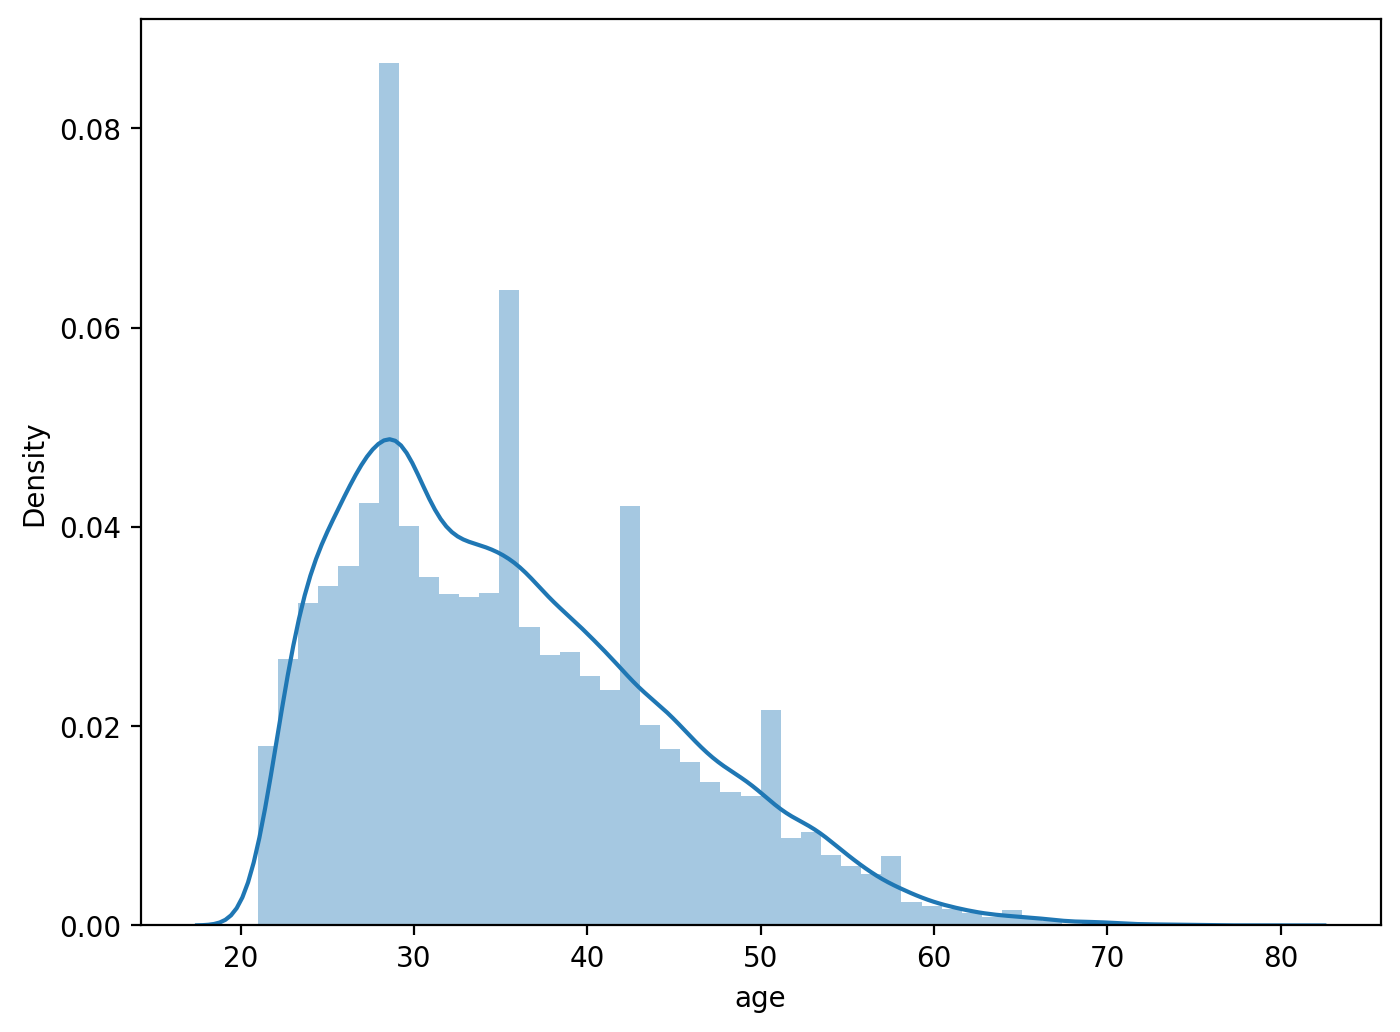

In [21]:
sns.distplot(df.age)

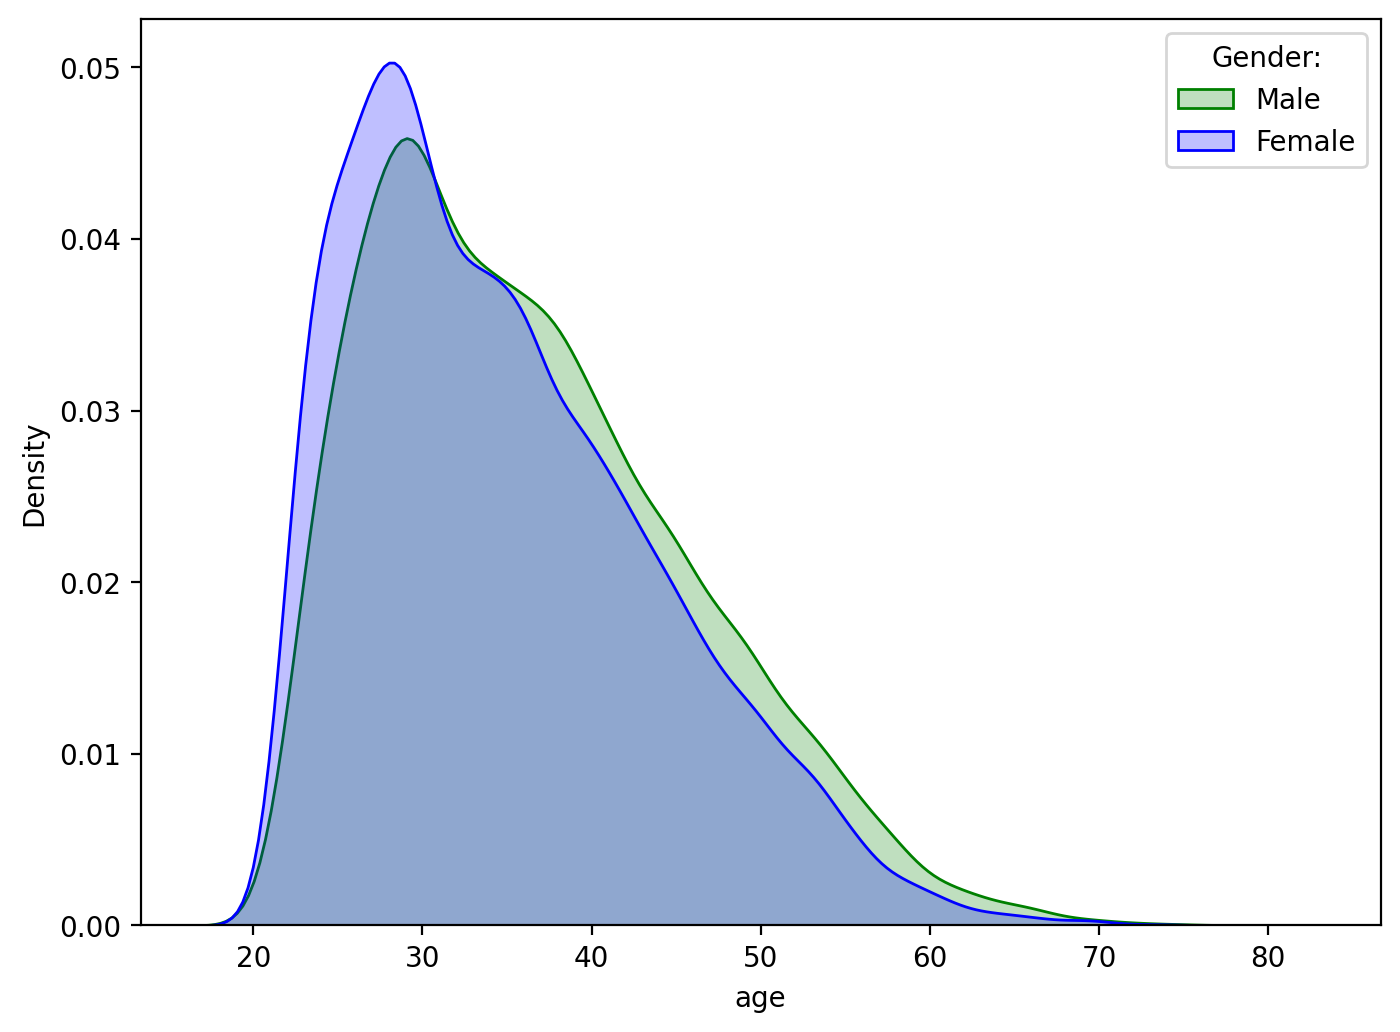

In [22]:
sns.distplot(df.loc[df.sex=='Male', 'age'], 
             hist=False, color='green', 
             kde_kws={'shade': True},
             label='Male')
sns.distplot(df.loc[df.sex=='Female', 'age'], 
             hist=False, color='blue', 
             kde_kws={'shade': True},
             label='Female')
plt.legend(title='Gender:')
plt.show()

In [23]:
px.histogram(df, x='age', title = 'Distribution of age')

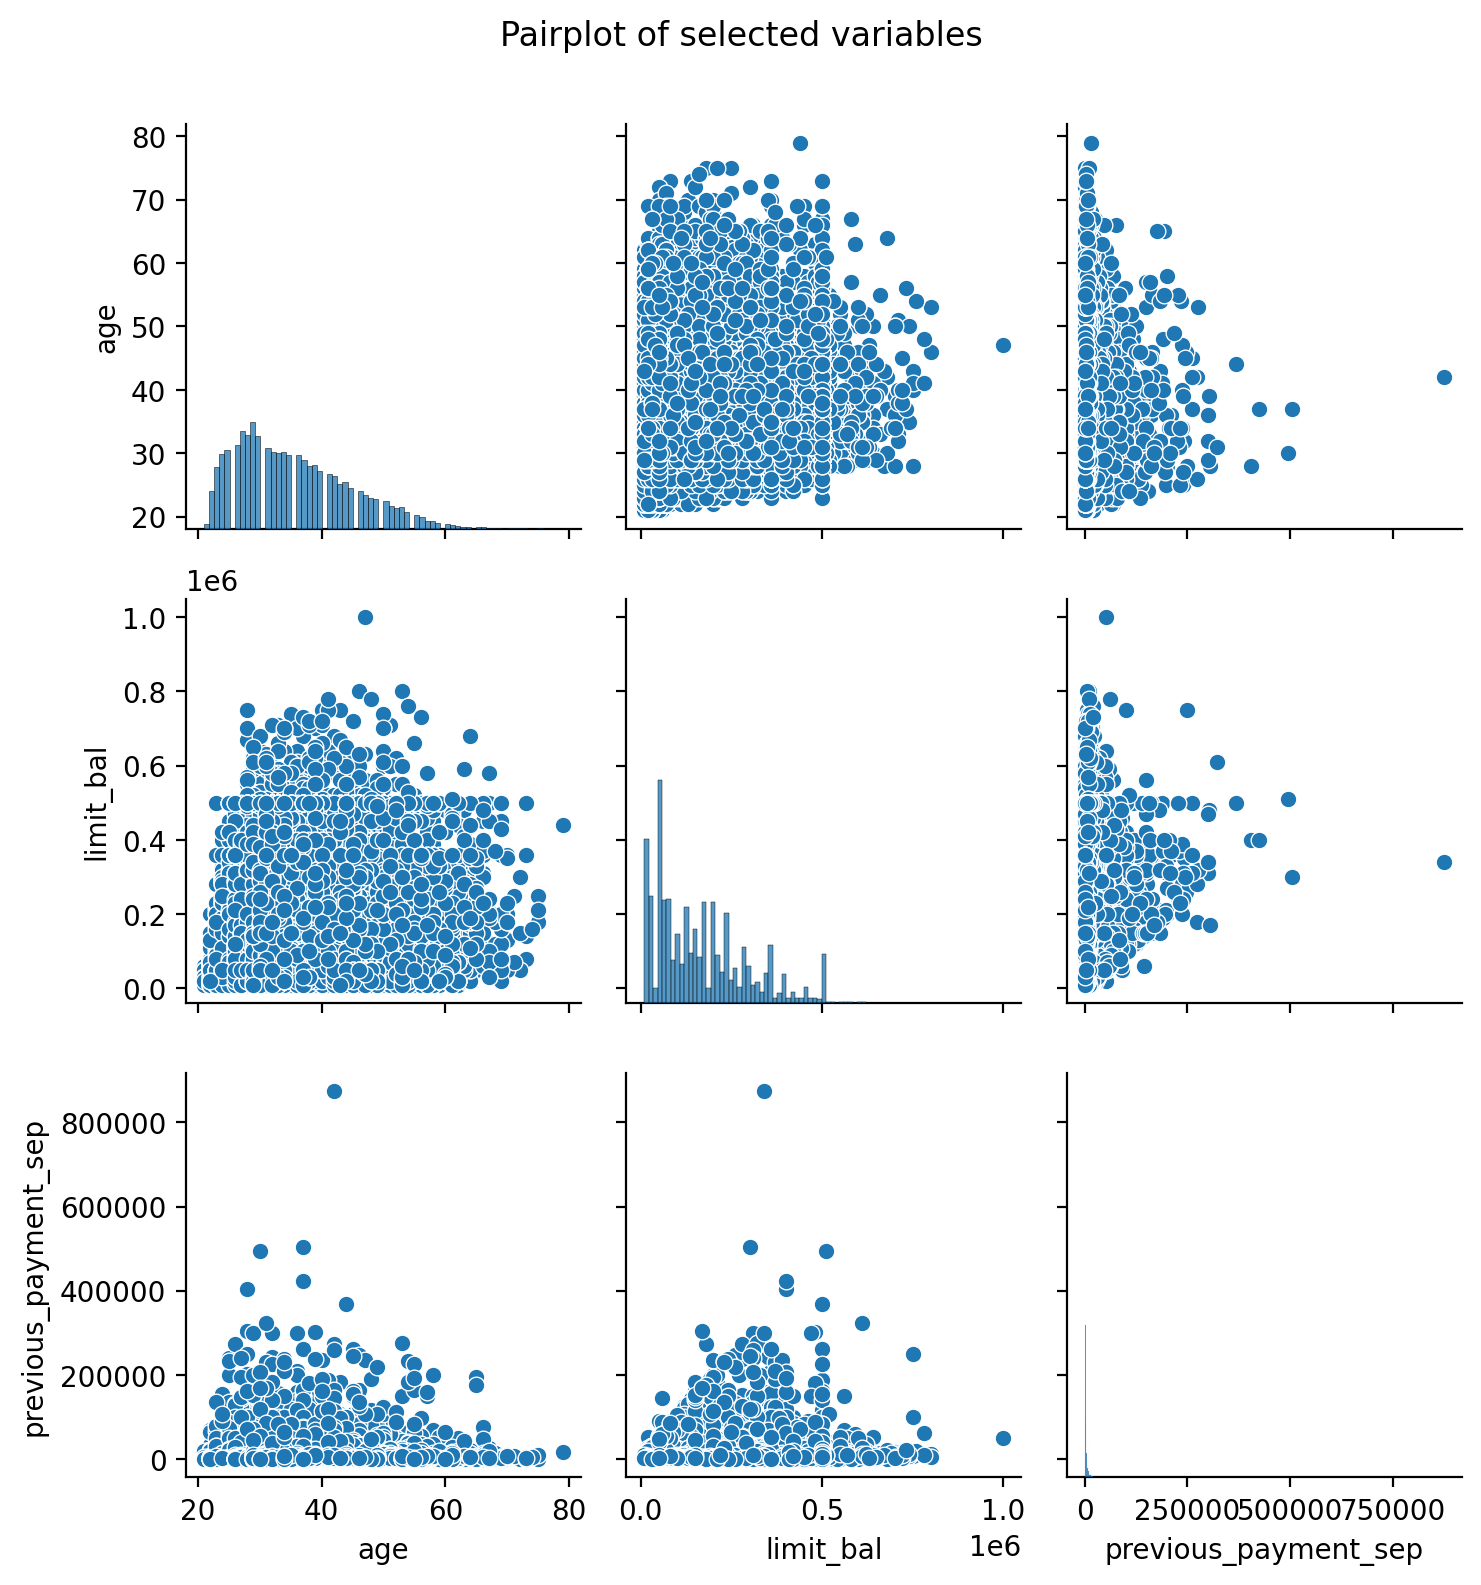

In [24]:
pair_plot = sns.pairplot(df[['age', 'limit_bal', 'previous_payment_sep']])
pair_plot.fig.suptitle('Pairplot of selected variables', y=1.05)

plt.tight_layout()
# plt.savefig('images/ch8_im6.png', bbox_inches='tight')
plt.show()

### 성별을 구분 (hue)

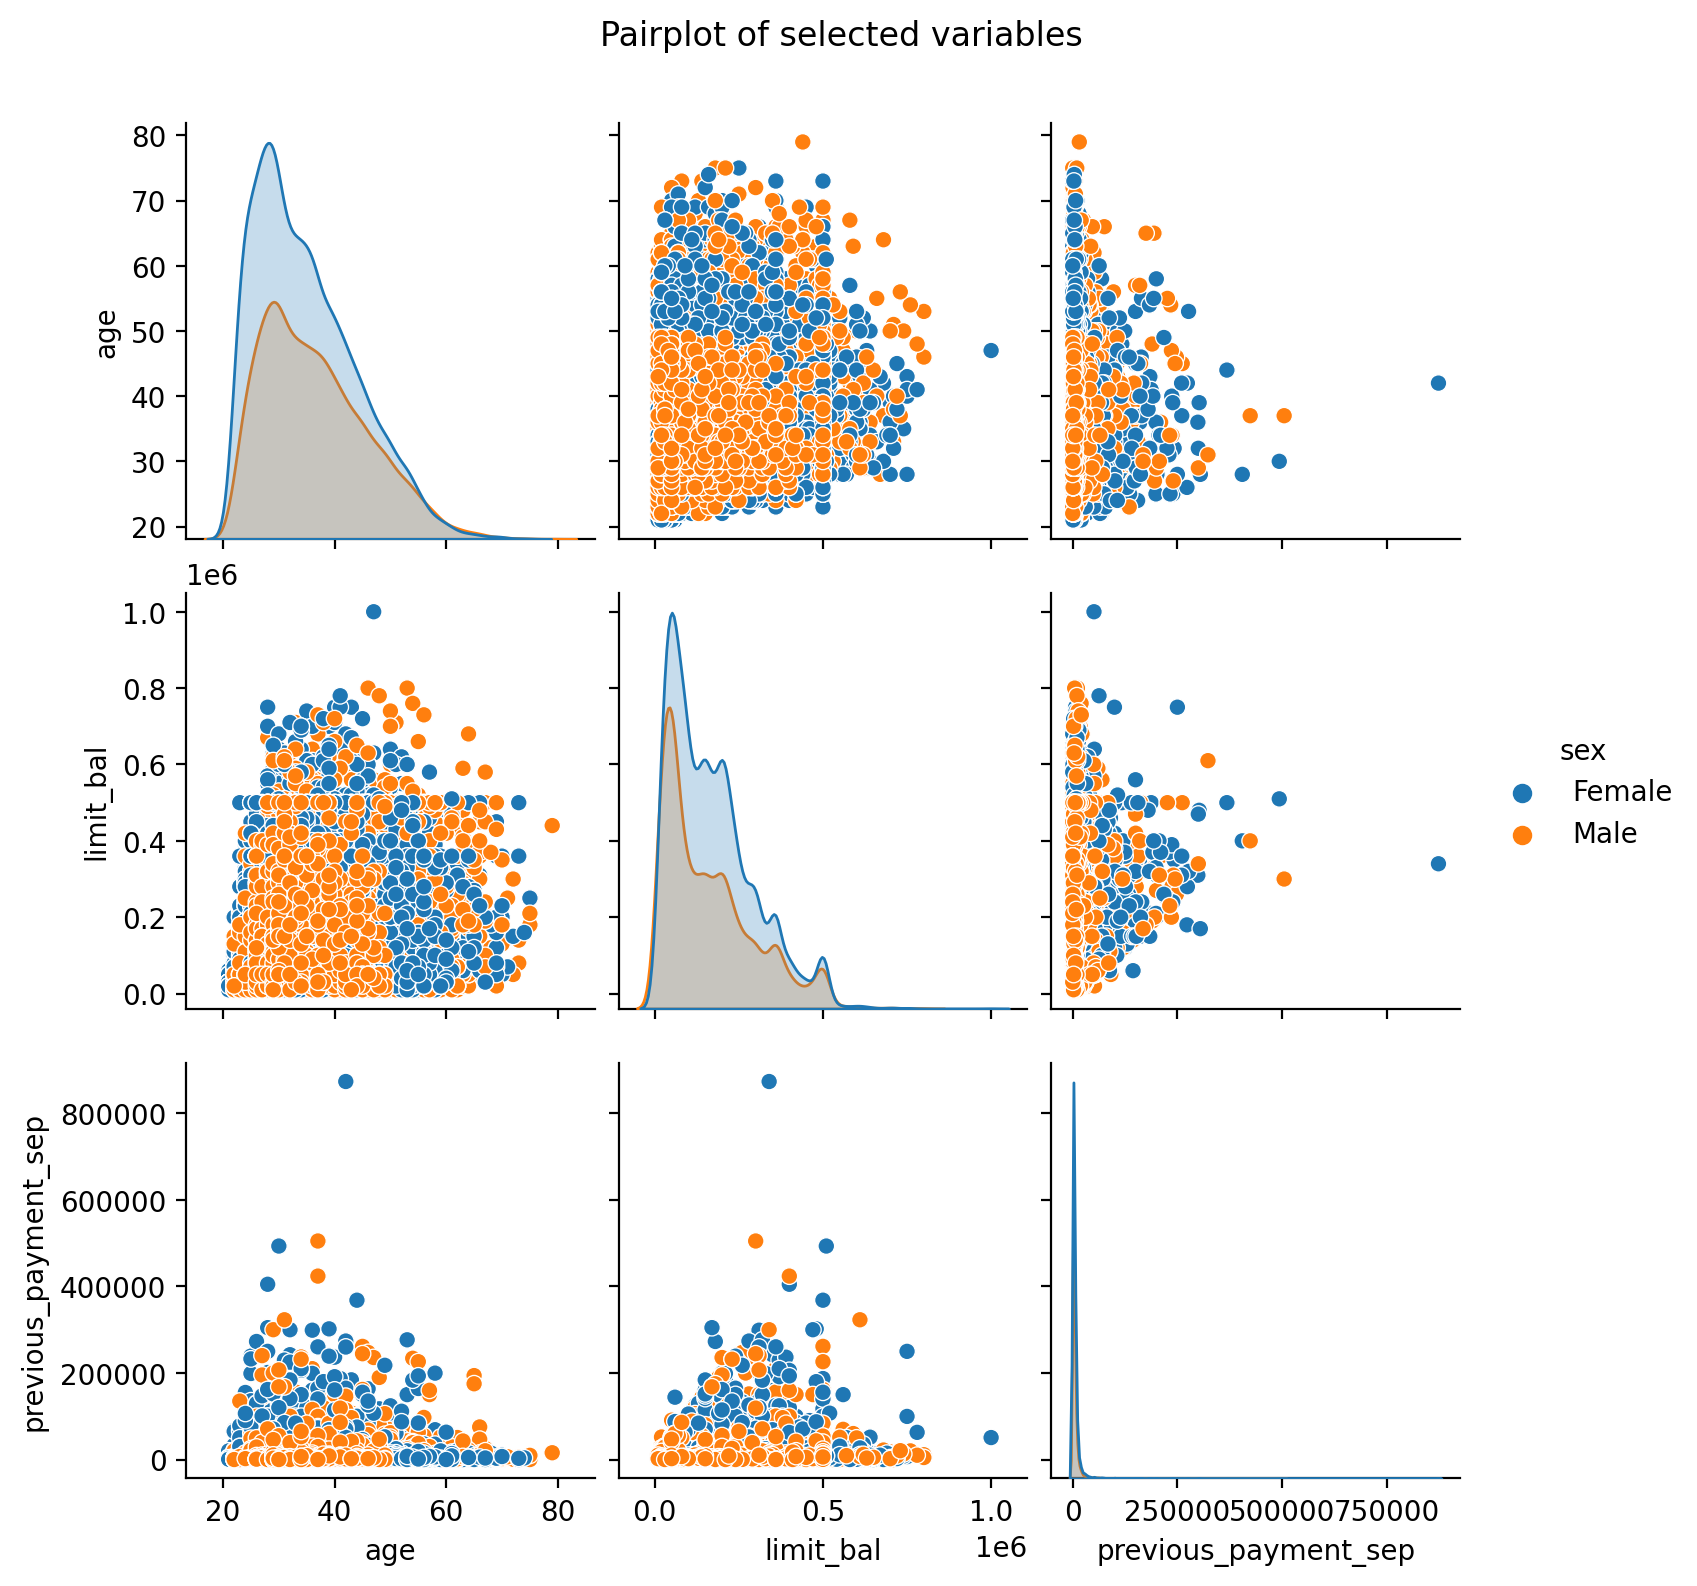

In [25]:
pair_plot = sns.pairplot(df[['sex', 'age', 'limit_bal', 'previous_payment_sep']], 
                         hue='sex')
pair_plot.fig.suptitle('Pairplot of selected variables', y=1.05);

6. Define and run a function for plotting the correlation heatmap:

In [26]:
def plot_correlation_matrix(corr_mat):
    # temporarily change style
    sns.set(style='white')
    # mask the upper triangle
    mask = np.zeros_like(corr_mat, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # set up the matplotlib figure
    fig, ax = plt.subplots()
    # set up custom diverging colormap
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    # plot the heatmap
    sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, 
                cbar_kws={'shrink': .5}, ax=ax)
    ax.set_title('Correlation Matrix', fontsize=16)
    # change back to darkgrid style
    sns.set(style='darkgrid')

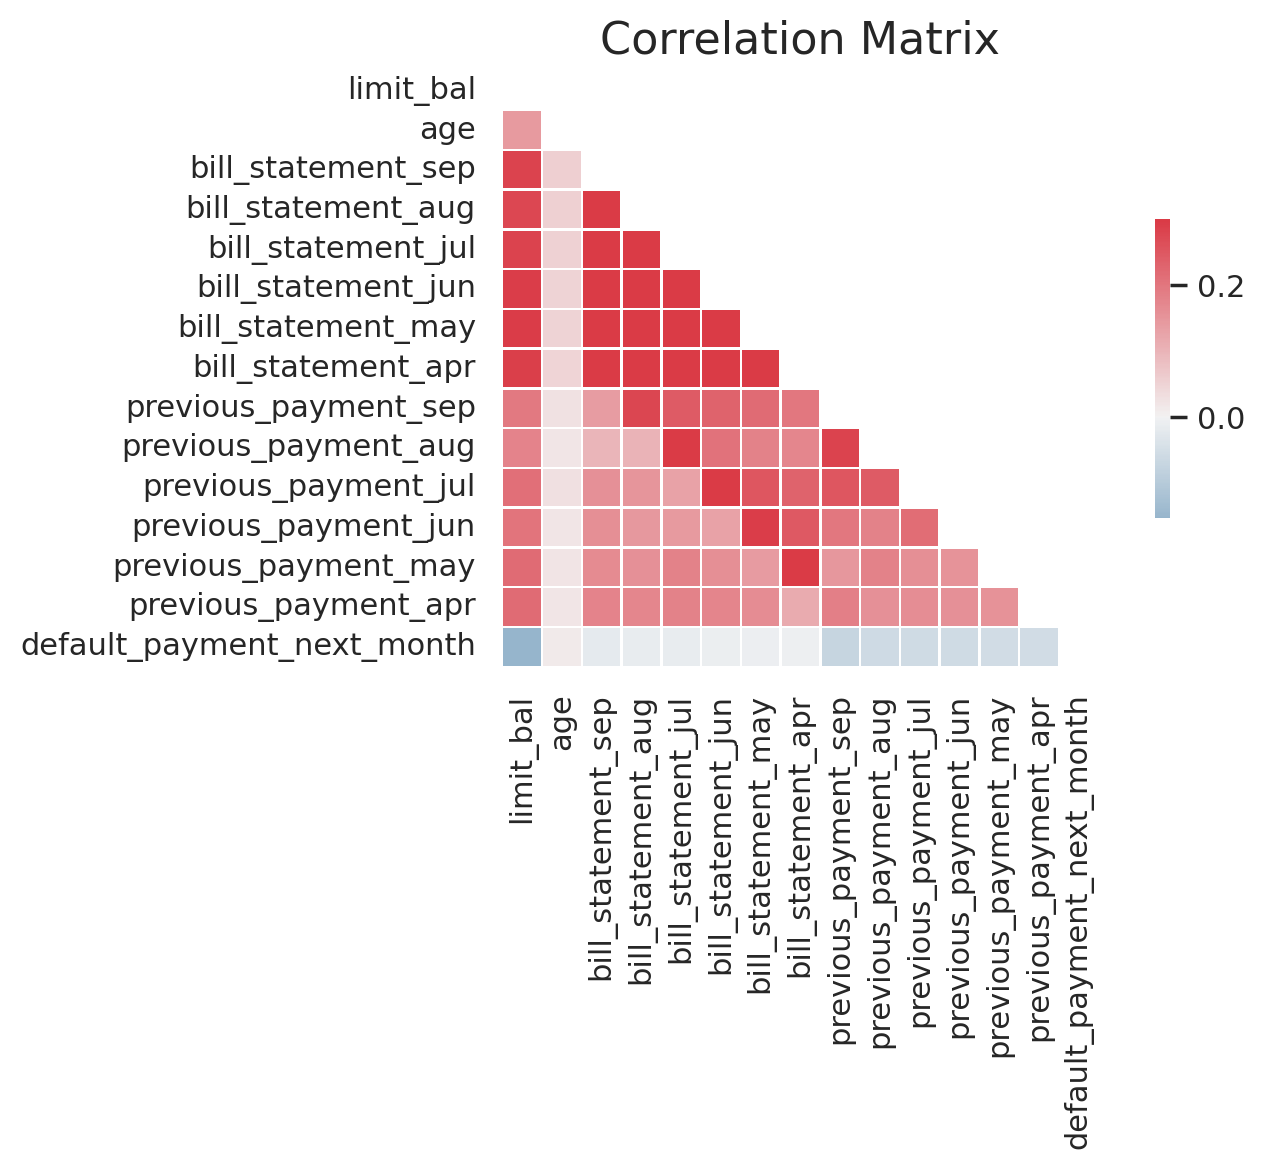

In [27]:
corr_mat = df.select_dtypes(include='number').corr()    
plot_correlation_matrix(corr_mat)

plt.tight_layout()
#plt.savefig('images/ch8_im7.png')
plt.show()

### 목적 변수와의 상관계수

In [28]:
df.select_dtypes(include='number').corr()[['default_payment_next_month']]

,default_payment_next_month
limit_bal,-0.153520
age,0.013890
bill_statement_sep,-0.019644
bill_statement_aug,-0.014193
bill_statement_jul,-0.014076
bill_statement_jun,-0.010156
bill_statement_may,-0.006760
bill_statement_apr,-0.005372
previous_payment_sep,-0.072929
previous_payment_aug,-0.058579


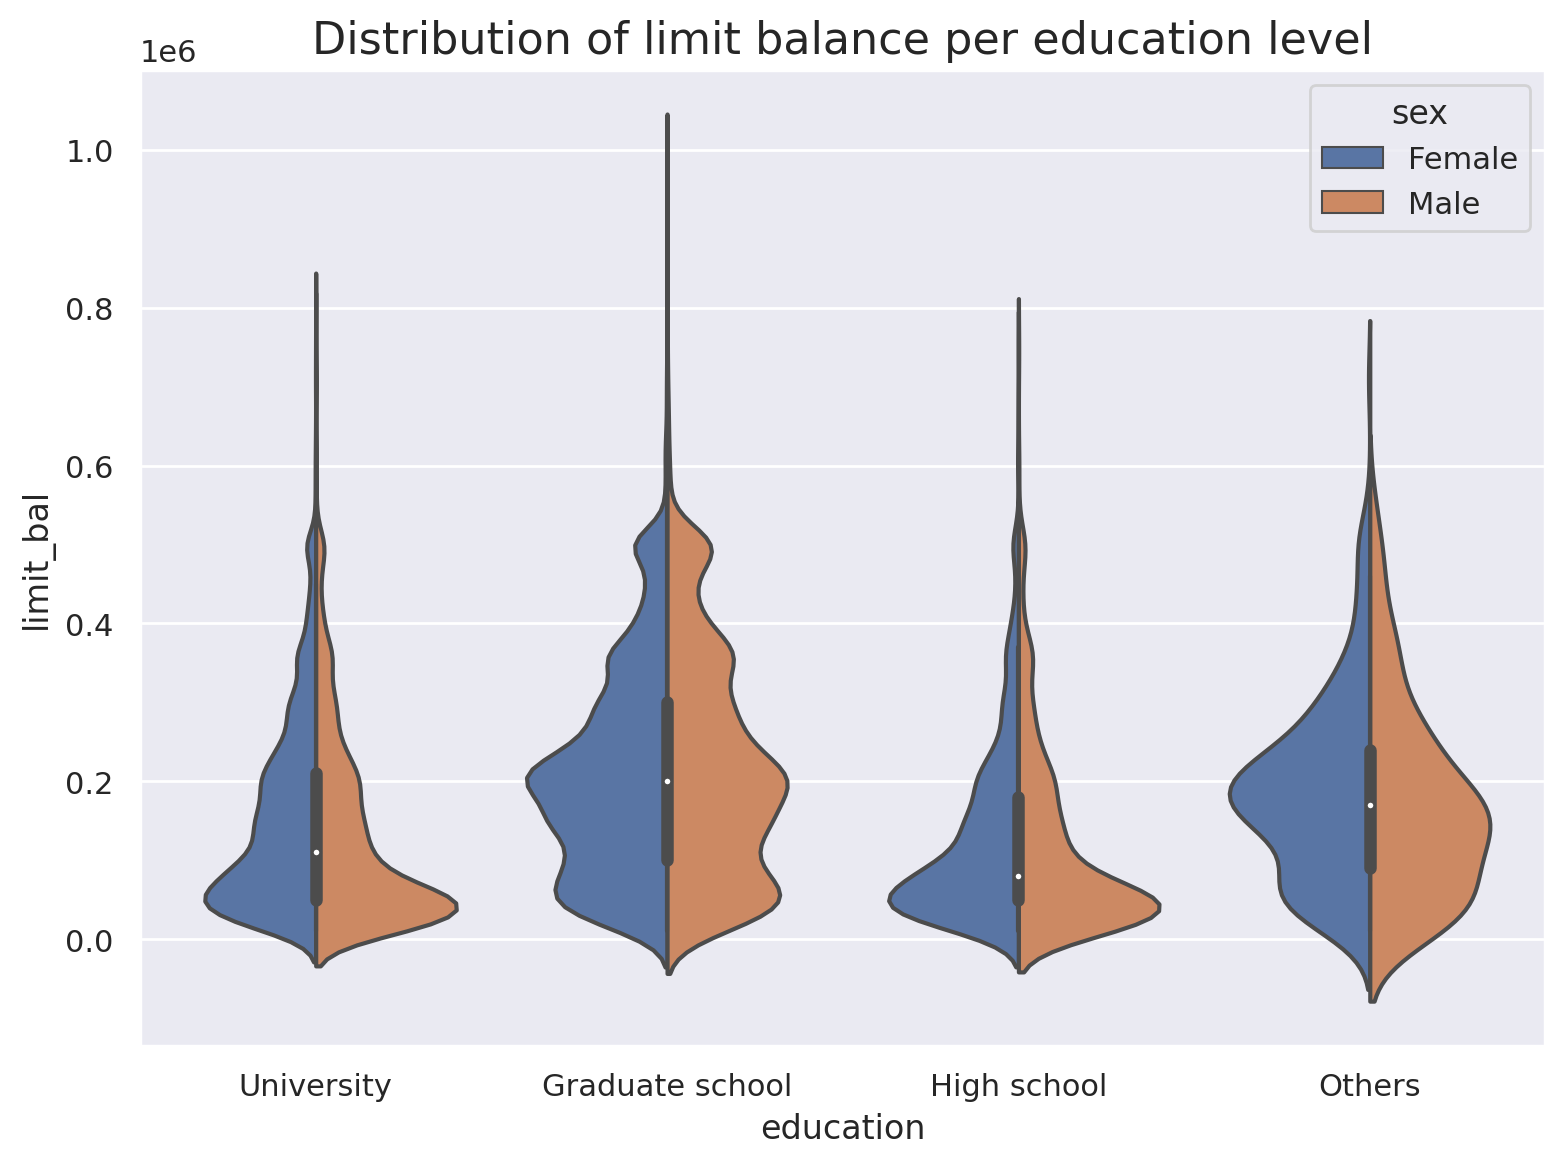

In [29]:
ax = sns.violinplot(x='education', y='limit_bal', 
                    hue='sex', split=True, data=df)
ax.set_title('Distribution of limit balance per education level', 
             fontsize=16)

plt.tight_layout()
# plt.savefig('images/ch8_im8.png')
plt.show()

8. Investigate the distribution of the target variable per gender and education level:

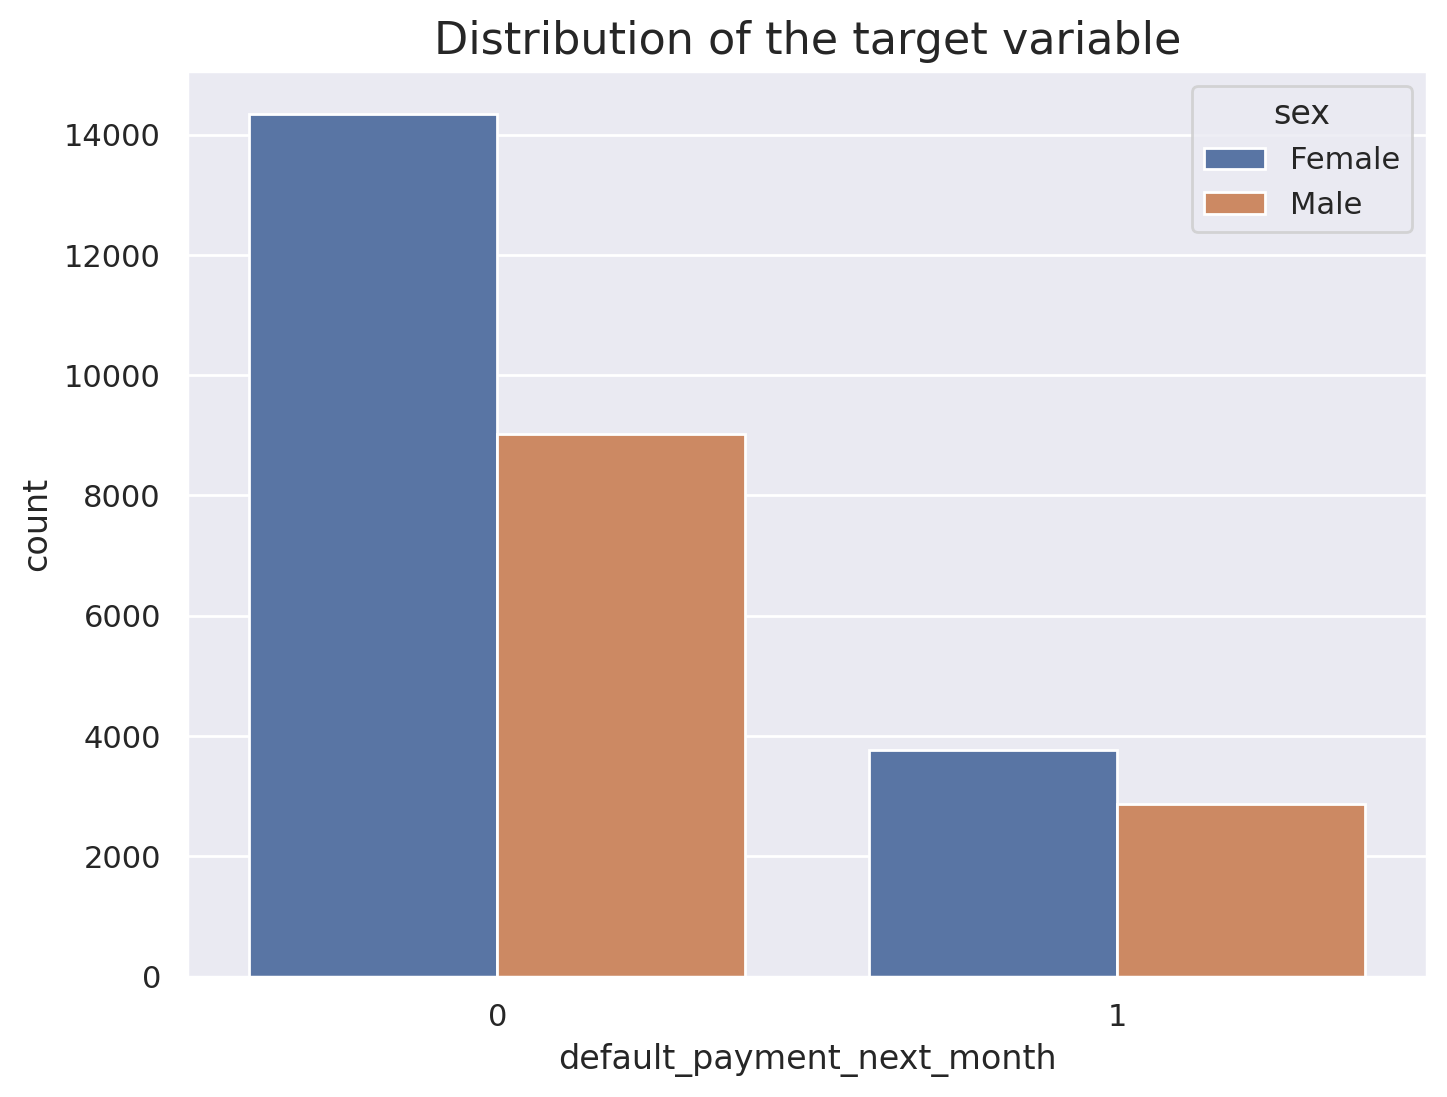

In [30]:
ax = sns.countplot('default_payment_next_month', hue='sex', 
                   data=df, orient='h')
ax.set_title('Distribution of the target variable', fontsize=16)

# plt.tight_layout()
# plt.savefig('images/ch8_im9.png')
plt.show()

### 비율 보기|

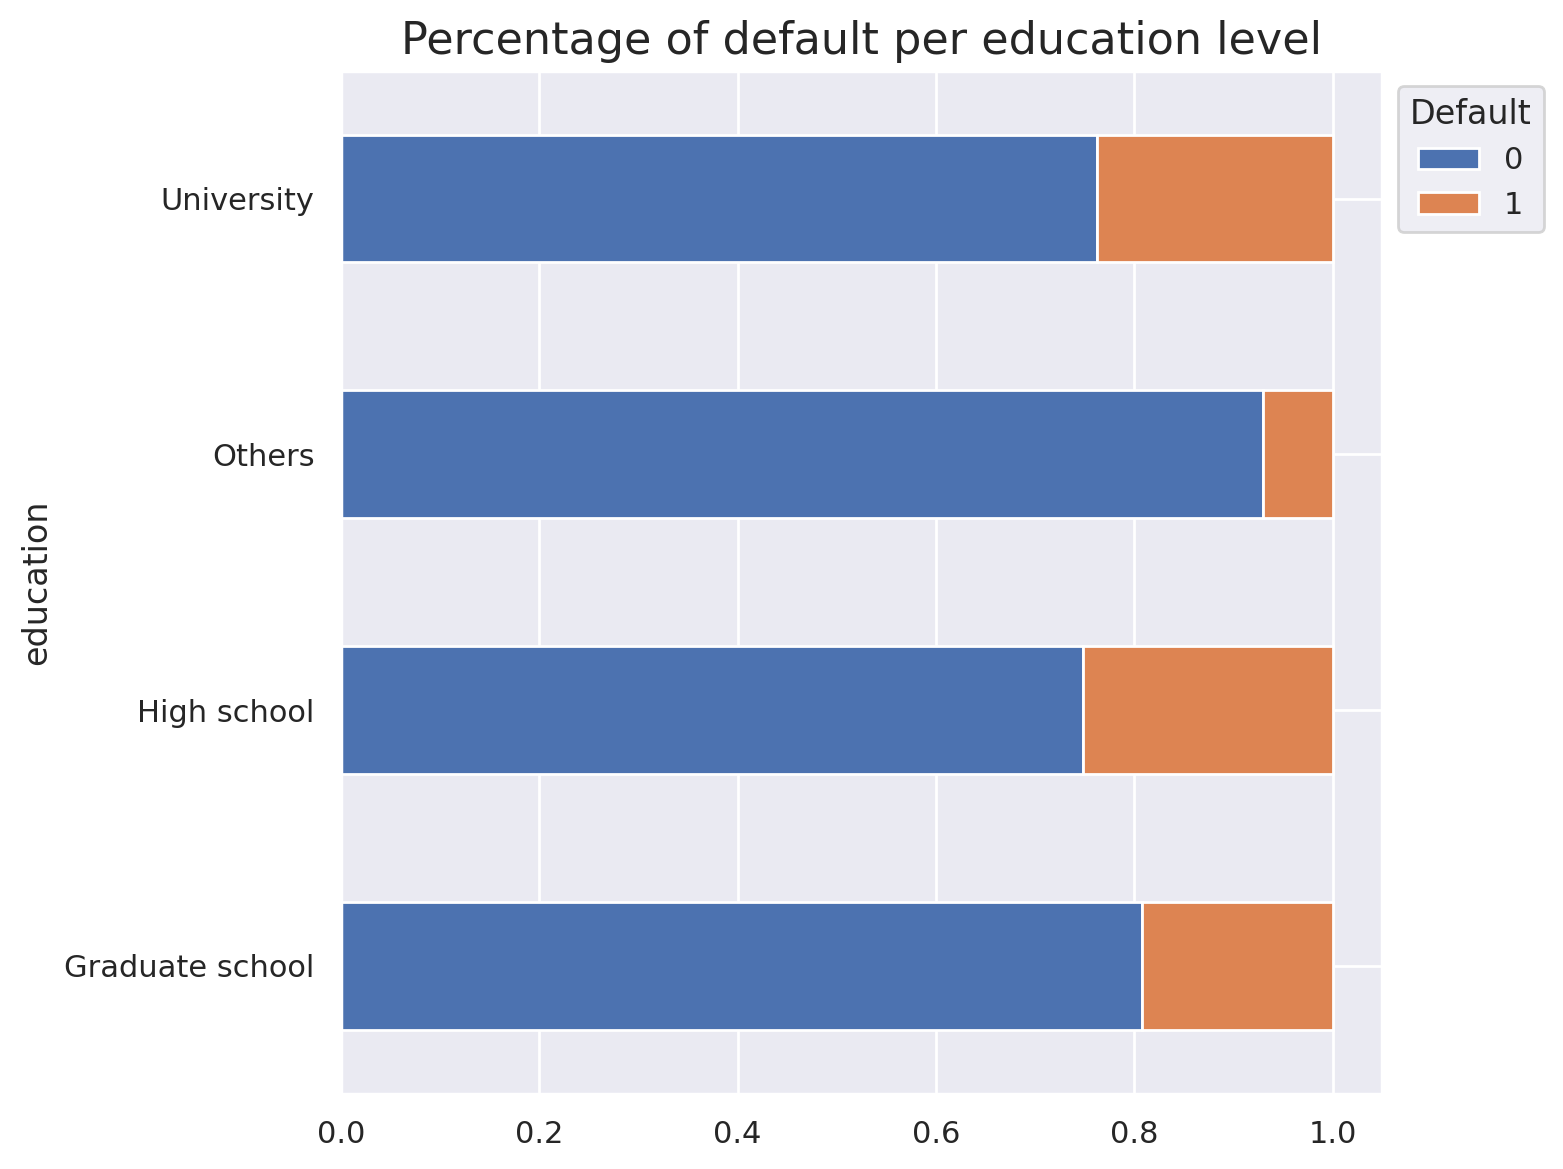

In [31]:
ax = df.groupby('education')['default_payment_next_month'] \
       .value_counts(normalize=True) \
       .unstack() \
       .plot(kind='barh', stacked='True')
ax.set_title('Percentage of default per education level', 
             fontsize=16)
ax.legend(title='Default', bbox_to_anchor=(1,1)) 

plt.tight_layout()
# plt.savefig('images/ch8_im10.png')
plt.show()

In [32]:
X.describe(include='object').T

,count,unique,top,freq
sex,30000,2,Female,18112
education,30000,4,University,14030
marriage,30000,3,Single,15964
payment_status_sep,30000,10,Unknown,17496
payment_status_aug,30000,10,Unknown,19512
payment_status_jul,30000,10,Unknown,19849
payment_status_jun,30000,10,Unknown,20803
payment_status_may,30000,9,Unknown,21493
payment_status_apr,30000,9,Unknown,21181


In [138]:
X.shape

(30000, 23)

In [139]:
CAT_FEATURES = X.select_dtypes(include='object').columns.to_list()
CAT_FEATURES

['sex',
 'education',
 'marriage',
 'payment_status_sep',
 'payment_status_aug',
 'payment_status_jul',
 'payment_status_jun',
 'payment_status_may',
 'payment_status_apr']

In [140]:
INT_FEATURES = X.select_dtypes(include=['int', 'float']).columns.to_list()
INT_FEATURES

['limit_bal',
 'age',
 'bill_statement_sep',
 'bill_statement_aug',
 'bill_statement_jul',
 'bill_statement_jun',
 'bill_statement_may',
 'bill_statement_apr',
 'previous_payment_sep',
 'previous_payment_aug',
 'previous_payment_jul',
 'previous_payment_jun',
 'previous_payment_may',
 'previous_payment_apr']

In [141]:
X_cat = pd.get_dummies(X, columns=CAT_FEATURES)

In [142]:
X_cat.shape

(30000, 81)

In [143]:
X_scale = X_cat.copy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scale[INT_FEATURES] = scaler.fit_transform(X_cat[INT_FEATURES])
X_scale

,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,sex_Female,sex_Male,education_Graduate school,education_High school,education_Others,education_University,marriage_Married,marriage_Others,marriage_Single,payment_status_sep_Payed duly,payment_status_sep_Payment delayed 1 month,payment_status_sep_Payment delayed 2 months,payment_status_sep_Payment delayed 3 months,payment_status_sep_Payment delayed 4 months,payment_status_sep_Payment delayed 5 months,payment_status_sep_Payment delayed 6 months,payment_status_sep_Payment delayed 7 months,payment_status_sep_Payment delayed 8 months,payment_status_sep_Unknown,payment_status_aug_Payed duly,payment_status_aug_Payment delayed 1 month,payment_status_aug_Payment delayed 2 months,payment_status_aug_Payment delayed 3 months,payment_status_aug_Payment delayed 4 months,payment_status_aug_Payment delayed 5 months,payment_status_aug_Payment delayed 6 months,...,payment_status_aug_Payment delayed 8 months,payment_status_aug_Unknown,payment_status_jul_Payed duly,payment_status_jul_Payment delayed 1 month,payment_status_jul_Payment delayed 2 months,payment_status_jul_Payment delayed 3 months,payment_status_jul_Payment delayed 4 months,payment_status_jul_Payment delayed 5 months,payment_status_jul_Payment delayed 6 months,payment_status_jul_Payment delayed 7 months,payment_status_jul_Payment delayed 8 months,payment_status_jul_Unknown,payment_status_jun_Payed duly,payment_status_jun_Payment delayed 1 month,payment_status_jun_Payment delayed 2 months,payment_status_jun_Payment delayed 3 months,payment_status_jun_Payment delayed 4 months,payment_status_jun_Payment delayed 5 months,payment_status_jun_Payment delayed 6 months,payment_status_jun_Payment delayed 7 months,payment_status_jun_Payment delayed 8 months,payment_status_jun_Unknown,payment_status_may_Payed duly,payment_status_may_Payment delayed 2 months,payment_status_may_Payment delayed 3 months,payment_status_may_Payment delayed 4 months,payment_status_may_Payment delayed 5 months,payment_status_may_Payment delayed 6 months,payment_status_may_Payment delayed 7 months,payment_status_may_Payment delayed 8 months,payment_status_may_Unknown,payment_status_apr_Payed duly,payment_status_apr_Payment delayed 2 months,payment_status_apr_Payment delayed 3 months,payment_status_apr_Payment delayed 4 months,payment_status_apr_Payment delayed 5 months,payment_status_apr_Payment delayed 6 months,payment_status_apr_Payment delayed 7 months,payment_status_apr_Payment delayed 8 months,payment_status_apr_Unknown
0,-1.136720,-1.246020,-0.642501,-0.647399,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,-0.365981,-1.029047,-0.659219,-0.666747,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
2,-0.597202,-0.161156,-0.298560,-0.493899,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,-0.905498,0.164303,-0.057491,-0.013293,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,-0.905498,2.334029,-0.578618,-0.611318,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,0,1,0,0,0,1,1,0,0,1,

In [144]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_cat, y)
X_train, X_test, y_train, y_test = train_test_split(X_scale, y)

In [39]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [40]:
def show_clf_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [145]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
print("R2: ",dtc.score(X_test, y_test).round(4))
y_pred = dtc.predict(X_test)
show_clf_result(y_test, y_pred)

R2:  0.7237
[[4778 1065]
 [1007  650]]
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      5843
           1       0.38      0.39      0.39      1657

    accuracy                           0.72      7500
   macro avg       0.60      0.61      0.60      7500
weighted avg       0.73      0.72      0.73      7500



In [117]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [146]:
lin = SGDClassifier()
lin.fit(X_train, y_train)
print("R2: ",lin.score(X_test, y_test).round(4))
y_pred = lin.predict(X_test)
show_clf_result(y_test, y_pred)

R2:  0.8173
[[5624  219]
 [1151  506]]
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      5843
           1       0.70      0.31      0.42      1657

    accuracy                           0.82      7500
   macro avg       0.76      0.63      0.66      7500
weighted avg       0.80      0.82      0.79      7500



In [147]:
LR = LogisticRegression()
LR.fit(X_train, y_train)
print("R2: ",LR.score(X_test, y_test).round(4))
y_pred = LR.predict(X_test)
show_clf_result(y_test, y_pred)

R2:  0.8196
[[5590  253]
 [1100  557]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      5843
           1       0.69      0.34      0.45      1657

    accuracy                           0.82      7500
   macro avg       0.76      0.65      0.67      7500
weighted avg       0.80      0.82      0.79      7500



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [160]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print("R2: ",rfc.score(X_test, y_test).round(4))
y_pred = rfc.predict(X_test)
show_clf_result(y_test, y_pred)

R2:  0.8152
[[5523  320]
 [1066  591]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5843
           1       0.65      0.36      0.46      1657

    accuracy                           0.82      7500
   macro avg       0.74      0.65      0.67      7500
weighted avg       0.80      0.82      0.79      7500



In [158]:
from sklearn.ensemble import GradientBoostingClassifier


In [161]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
print("R2: ",gbc.score(X_test, y_test).round(4))
y_pred = gbc.predict(X_test)
show_clf_result(y_test, y_pred)

R2:  0.8207
[[5582  261]
 [1084  573]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      5843
           1       0.69      0.35      0.46      1657

    accuracy                           0.82      7500
   macro avg       0.76      0.65      0.68      7500
weighted avg       0.80      0.82      0.80      7500



In [ ]:
!pip install lightgbm

     |████████████████████████████████| 1.2 MB 2.7 MB/s eta 0:00:01


In [ ]:
# !conda install -c conda-forge lightgbm -y

In [45]:
from lightgbm import LGBMClassifier

In [162]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train, early_stopping_rounds=5, eval_set=(X_test, y_test), verbose=False)
print("R2: ",lgbm.score(X_test, y_test).round(4))
y_pred = lgbm.predict(X_test)
show_clf_result(y_test, y_pred)

R2:  0.8211
[[5580  263]
 [1079  578]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5843
           1       0.69      0.35      0.46      1657

    accuracy                           0.82      7500
   macro avg       0.76      0.65      0.68      7500
weighted avg       0.80      0.82      0.80      7500



In [1]:
def plot_feature_weight(feature, weight):
    plt.figure(figsize=(8,8))
    W = pd.DataFrame({'feature':feature,'weight':weight})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)

In [2]:
# def plot_features_weights(features, weights, N):
#     height = int(N/3)
#     W = pd.DataFrame({'Weights':weights}, features)
#     W[:N].sort_values(by='Weights', ascending=True).plot(kind='barh', 
#                         color='b', figsize=(8,height))
#     plt.gca().legend_ = None

plot_feature_weight(X_cat.columns, lgbm.feature_importances_)

NameError: name 'X_cat' is not defined

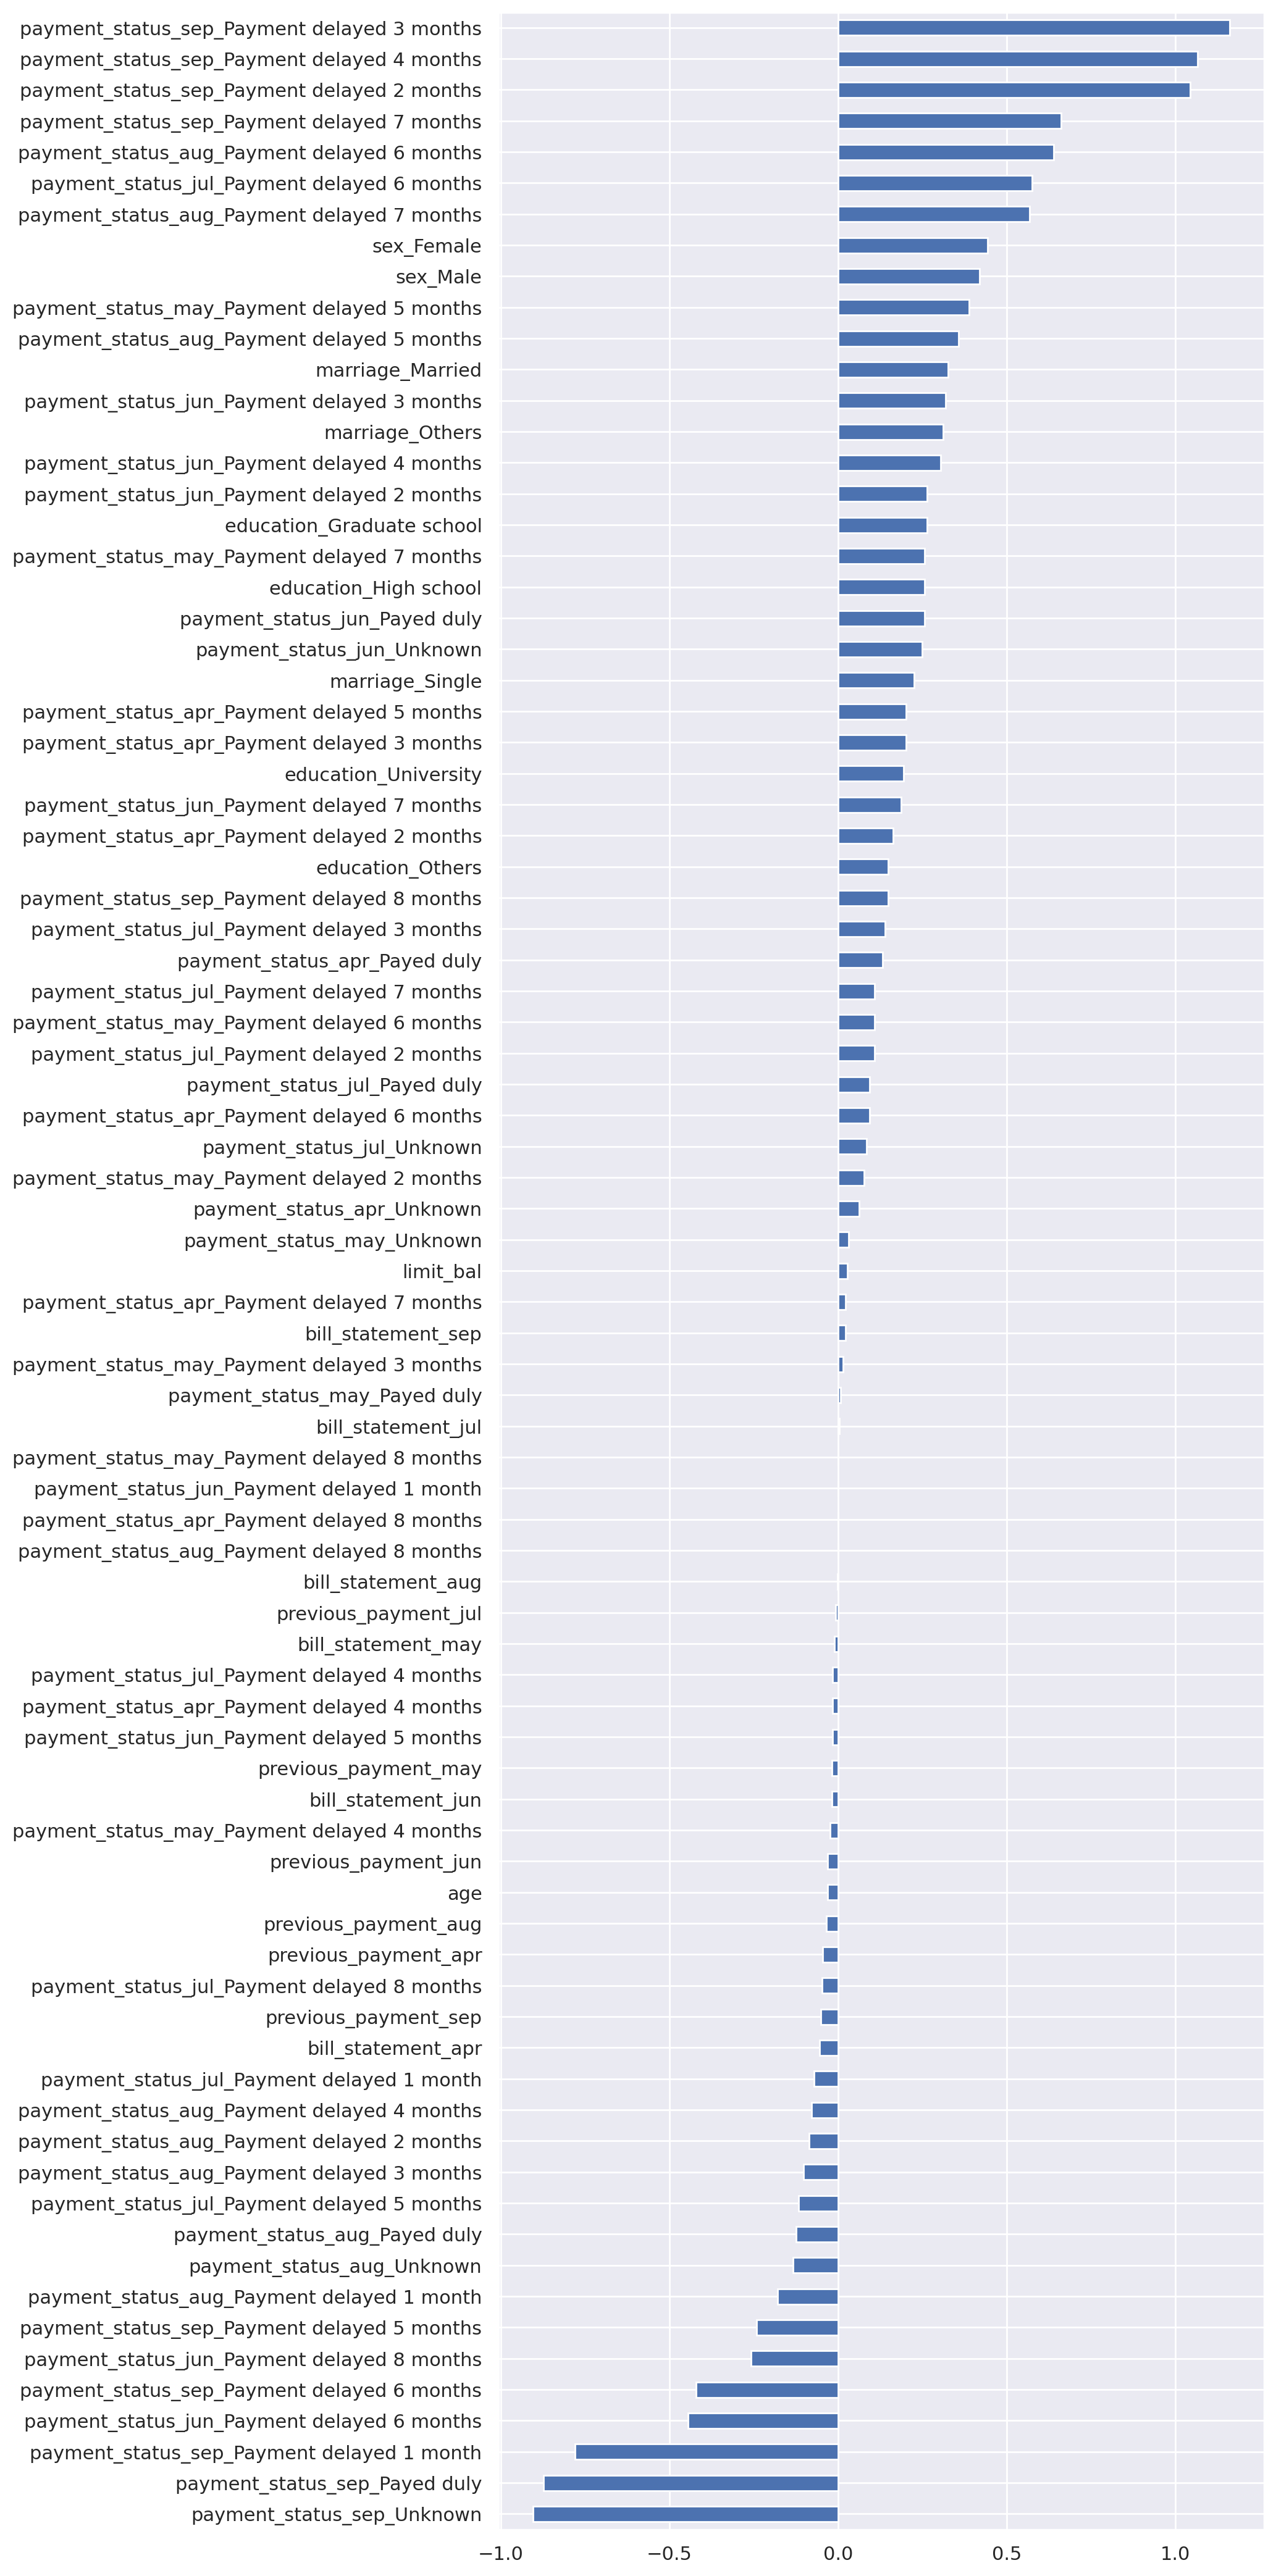

In [137]:
plot_features_weights(X_scale.columns, lin.coef_.ravel(), 81)

In [62]:
prob1_default = lgbm.predict_proba(X_test)[:,1]

In [80]:
y_pred_high_precesion = prob1_default > 0.8
show_clf_result(y_test, y_pred_high_precesion)

[[5752    4]
 [1721   23]]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      5756
           1       0.85      0.01      0.03      1744

    accuracy                           0.77      7500
   macro avg       0.81      0.51      0.45      7500
weighted avg       0.79      0.77      0.67      7500



In [81]:
y_pred_high_recall = prob1_default > 0.1
show_clf_result(y_test, y_pred_high_recall)

[[2041 3715]
 [ 156 1588]]
              precision    recall  f1-score   support

           0       0.93      0.35      0.51      5756
           1       0.30      0.91      0.45      1744

    accuracy                           0.48      7500
   macro avg       0.61      0.63      0.48      7500
weighted avg       0.78      0.48      0.50      7500



In [109]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_cat)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y)
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train, early_stopping_rounds=5, eval_set=(X_test, y_test), verbose=False)
print("R2: ",lgbm.score(X_test, y_test).round(4))
y_pred = lgbm.predict(X_test)
show_clf_result(y_test, y_pred)

R2:  0.8095
[[5538  292]
 [1137  533]]
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      5830
           1       0.65      0.32      0.43      1670

    accuracy                           0.81      7500
   macro avg       0.74      0.63      0.66      7500
weighted avg       0.79      0.81      0.78      7500



In [111]:
X_pca.shape

(30000, 20)